In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from alexNet_model_train import AlexNetFineTuner  # Import your AlexNet model class
import matplotlib.pyplot as plt

import os

In [2]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (AlexNet input size)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize with ImageNet means and stds
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [3]:
# Load CIFAR-10 dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use a subset for quick testing (optional)
from torch.utils.data import Subset
# test_dataset = Subset(test_dataset, range(500))  # 100 samples for testing

test_dataloader = DataLoader(test_dataset, batch_size=32)


Files already downloaded and verified


In [4]:
# Load CIFAR-10 dataset
full_train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training dataset into train/validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define pruning percentages
pruning_percentages = [0.1, 0.2]  # 0%, 10%, 20%, 30%

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def fine_tune_model(model, train_dataloader, val_dataloader, epochs=5, learning_rate=1e-5):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_correct = 0, 0

        # Training loop
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Validation loop
        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_acc = train_correct / len(train_dataloader.dataset)
        val_acc = val_correct / len(val_dataloader.dataset)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model

def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass through the model
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    all_preds_tensor = torch.tensor(all_preds)
    all_labels_tensor = torch.tensor(all_labels)
    return accuracy(all_preds_tensor, all_labels_tensor, task="multiclass", num_classes=10)

# List to store accuracies for each pruning percentage
accuracies = []

# Function to get indices of non-zero channels after pruning
def get_nonzero_indices(model):
    non_zero_indices = {}
    new_channels = {}

    for name, module in model.named_modules():
        # Check if the module is a layer with weights
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weights = module.weight.data
            indices = []

            # Iterate over output channels (dim 0)
            for out_idx in range(weights.shape[0]):  # dim 0 (output channels)
                if weights[out_idx].abs().sum() > 0:  # Check for non-zero weights
                    indices.append(out_idx)

            # Normalize the name by removing 'model.' prefix
            normalized_name = name.replace('model.', '')

            non_zero_indices[normalized_name] = indices
            out_channels = len(indices)
            in_channels = weights.shape[1] if len(weights.shape) > 2 else weights.shape[0]
            new_channels[normalized_name] = (out_channels, in_channels)

    return non_zero_indices, new_channels


def create_dense_model(original_model, non_zero_indices, new_channels):
    class DenseAlexNet(nn.Module):
        def __init__(self):
            super(DenseAlexNet, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, new_channels["features.0"][0], kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(
                    new_channels["features.0"][0],
                    new_channels["features.3"][0],
                    kernel_size=5,
                    padding=2
                ),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(
                    new_channels["features.3"][0],
                    new_channels["features.6"][0],
                    kernel_size=3,
                    padding=1
                ),
                nn.ReLU(inplace=True),
                nn.Conv2d(
                    new_channels["features.6"][0],
                    new_channels["features.8"][0],
                    kernel_size=3,
                    padding=1
                ),
                nn.ReLU(inplace=True),
                nn.Conv2d(
                    new_channels["features.8"][0],
                    new_channels["features.10"][0],
                    kernel_size=3,
                    padding=1
                ),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2)
            )

            self.classifier = nn.Sequential(
                nn.Linear(new_channels["features.10"][0] * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 10),
            )

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x

    return DenseAlexNet()



# Function to copy weights from pruned to dense model
def copy_weights(pruned_model, dense_model, non_zero_indices):
    for (name, module), (_, dense_module) in zip(pruned_model.named_modules(), dense_model.named_modules()):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if name in non_zero_indices:
                indices = non_zero_indices[name]
                for idx_out, idx_in in indices:
                    dense_module.weight.data[idx_out].copy_(module.weight.data[idx_out])
                if module.bias is not None:
                    dense_module.bias.data.copy_(module.bias.data)

def visualize_weights(weights, title="Pruned Weights in Conv1", save_path=None, name=None):
    """
    Visualizes and optionally saves the weights of a convolutional layer as 2D images,
    where each image corresponds to one filter in the layer.

    Parameters:
        weights (torch.Tensor): The weight tensor of shape (out_channels, in_channels, height, width).
        title (str): Title for the plot.
        save_path (str): Directory where the image will be saved (optional).
        name (str): Filename for the saved image (optional).
    """
    # Check if the weights tensor is 4D
    if len(weights.shape) != 4:
        raise ValueError(f"Expected 4D weight tensor (Conv2D), but got shape: {weights.shape}")
    
    out_channels, in_channels, height, width = weights.shape

    # Set up subplots to display each output channel
    n_cols = min(8, out_channels)  # Set the number of columns
    n_rows = (out_channels + n_cols - 1) // n_cols  # Calculate the number of rows based on columns

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle(title, fontsize=16)

    # Loop through each filter (output channel) and plot it
    for i in range(out_channels):
        # Visualize the first input channel of each filter
        kernel = weights[i, 0].cpu().detach().numpy()

        # Determine the plot position
        if n_rows > 1:
            ax = axes[i // n_cols, i % n_cols]
        else:
            ax = axes[i % n_cols]
        
        ax.imshow(kernel, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Filter {i}")

    # Hide any remaining empty subplots
    if n_rows > 1:
        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes.flatten()[j])

    # Adjust layout
    plt.tight_layout()

    # Save the visualization if save_path and name are provided
    if save_path and name:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, name))
        print(f"Pruned weights visualization saved to {os.path.join(save_path, name)}")
    else:
        plt.show()


In [6]:
# Loop through each pruning percentage
for amount in pruning_percentages:
    # Reload the model from the checkpoint for each pruning level to start fresh
    checkpoint_path = "../checkpointsAlex/best-checkpoint.ckpt"  # Path to your saved checkpoint
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path)
    model.to(device)
    
    # Apply pruning if amount > 0
    if amount > 0:
        # Prune the weights of convolutional and linear layers
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
                prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
    
    # Fine-tune the model after pruning
    print(f"Fine-tuning the model after pruning {amount*100:.0f}% of weights...")
    model = fine_tune_model(model, train_dataloader, val_dataloader, epochs=3, learning_rate=1e-5)
    
    non_zero_indices, new_channels = get_nonzero_indices(model)
    print("Keys in new_channels:", new_channels.keys())

    dense_model = create_dense_model(model, non_zero_indices, new_channels)
    copy_weights(model, dense_model, non_zero_indices)

     # Verify the dense model
    print("Original Model:", model)
    print("Dense Model:", dense_model)

    # Evaluate and store accuracy
    test_accuracy = evaluate_model(model, test_dataloader)
    accuracies.append(test_accuracy.item())
    print(f"Test Accuracy after Pruning {amount*100:.0f}% of weights: {test_accuracy:.4f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fine-tuning the model after pruning 10% of weights...
Epoch 1/3, Train Loss: 326.4104, Train Acc: 0.9097, Val Loss: 41.4047, Val Acc: 0.9535
Epoch 2/3, Train Loss: 111.2548, Train Acc: 0.9702, Val Loss: 32.4153, Val Acc: 0.9641
Epoch 3/3, Train Loss: 57.4321, Train Acc: 0.9864, Val Loss: 30.3998, Val Acc: 0.9660
Keys in new_channels: dict_keys(['features.0', 'features.3', 'features.6', 'features.8', 'features.10', 'classifier.1', 'classifier.4', 'classifier.6'])
Original Model: AlexNetFineTuner(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), 

In [7]:
print("Accuracy for ln structured", accuracies)

Accuracy for ln structured [0.9100000262260437, 0.8095999956130981]


Visualizing weights for model.features.0
Pruned weights visualization saved to ./plots/model_features_0_pruned_weights.png
Visualizing weights for model.features.3
Pruned weights visualization saved to ./plots/model_features_3_pruned_weights.png
Visualizing weights for model.features.6
Pruned weights visualization saved to ./plots/model_features_6_pruned_weights.png
Visualizing weights for model.features.8
Pruned weights visualization saved to ./plots/model_features_8_pruned_weights.png
Visualizing weights for model.features.10
Pruned weights visualization saved to ./plots/model_features_10_pruned_weights.png


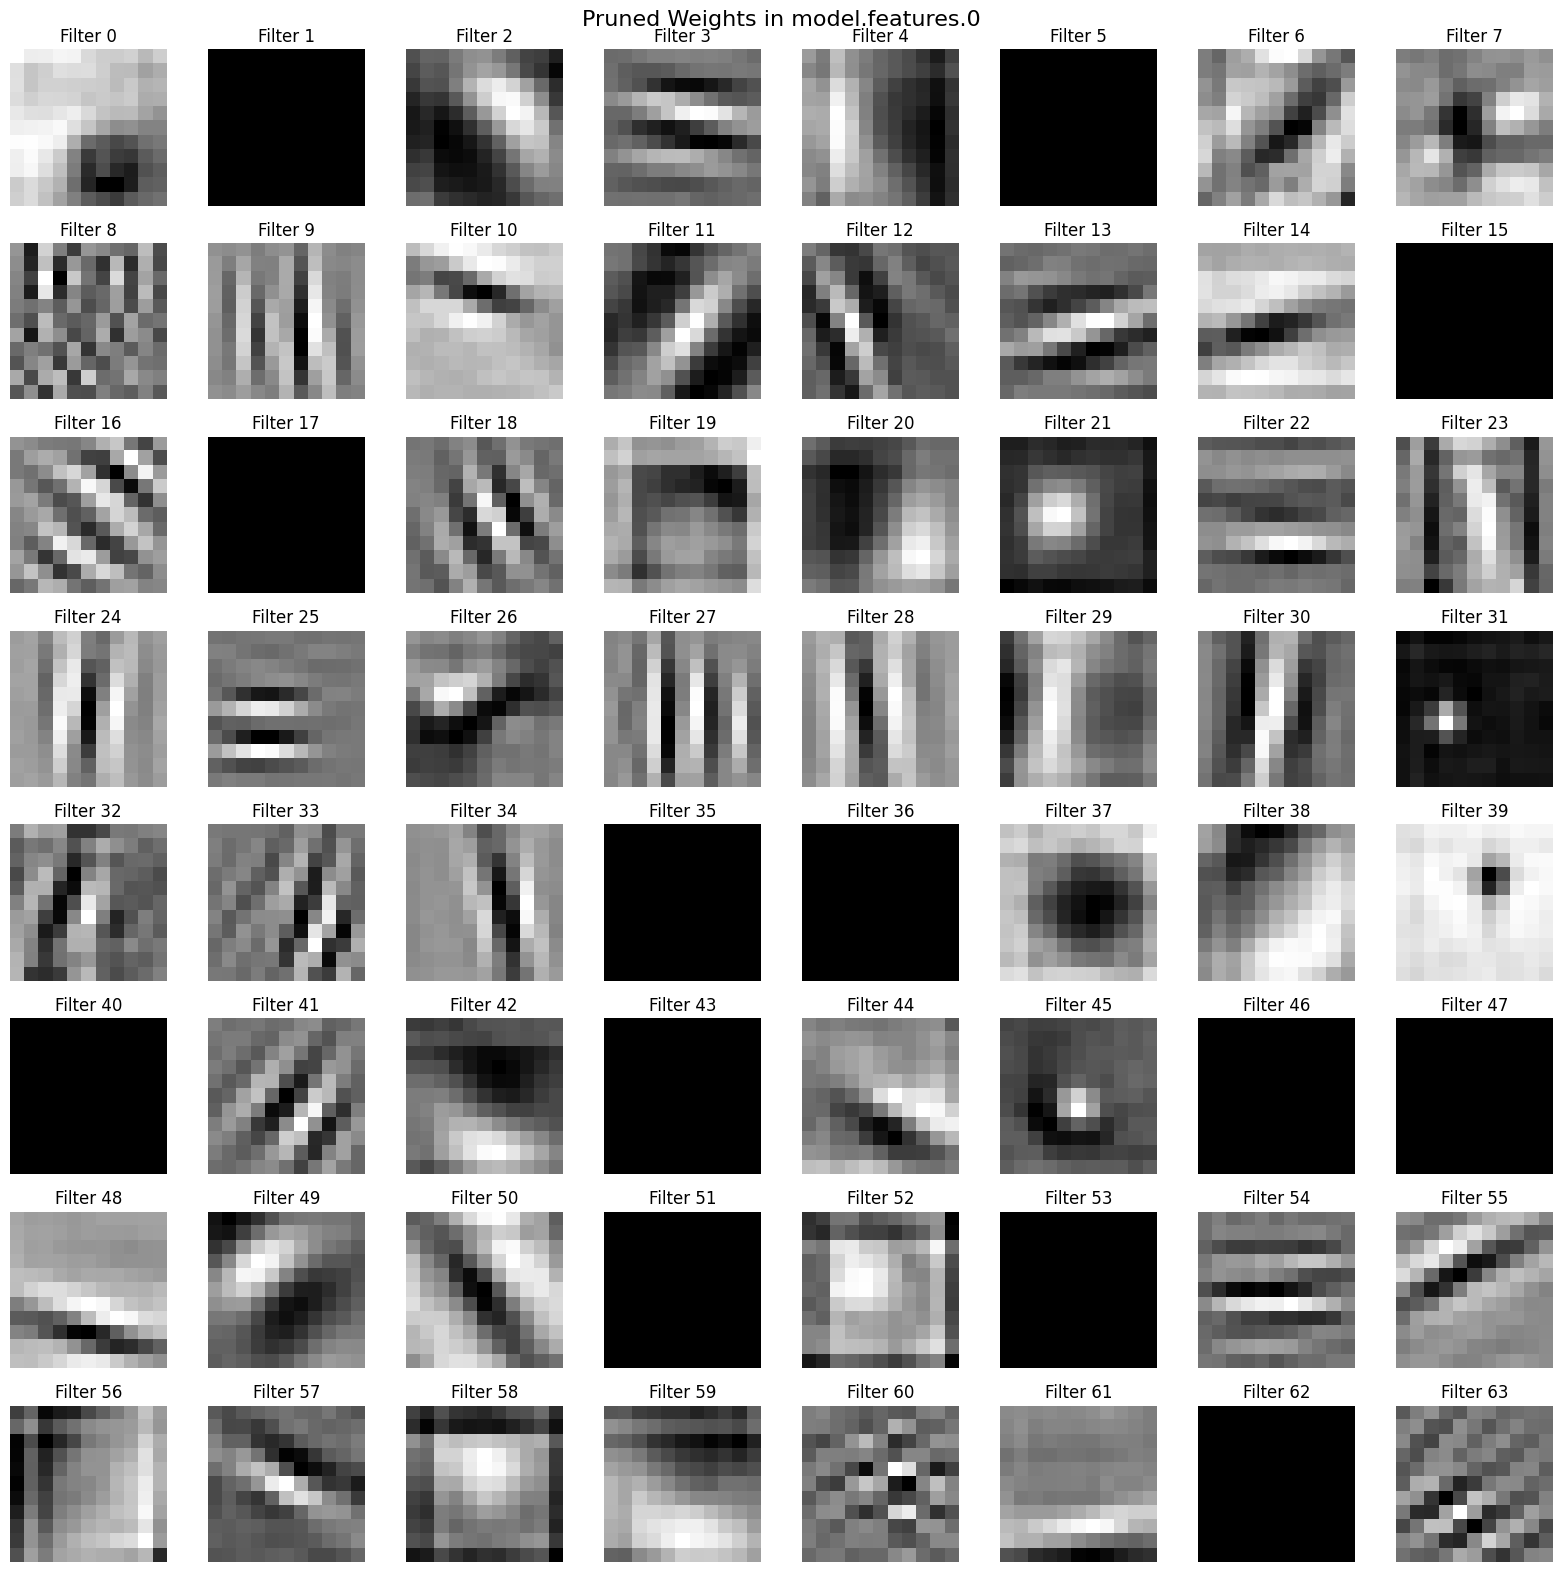

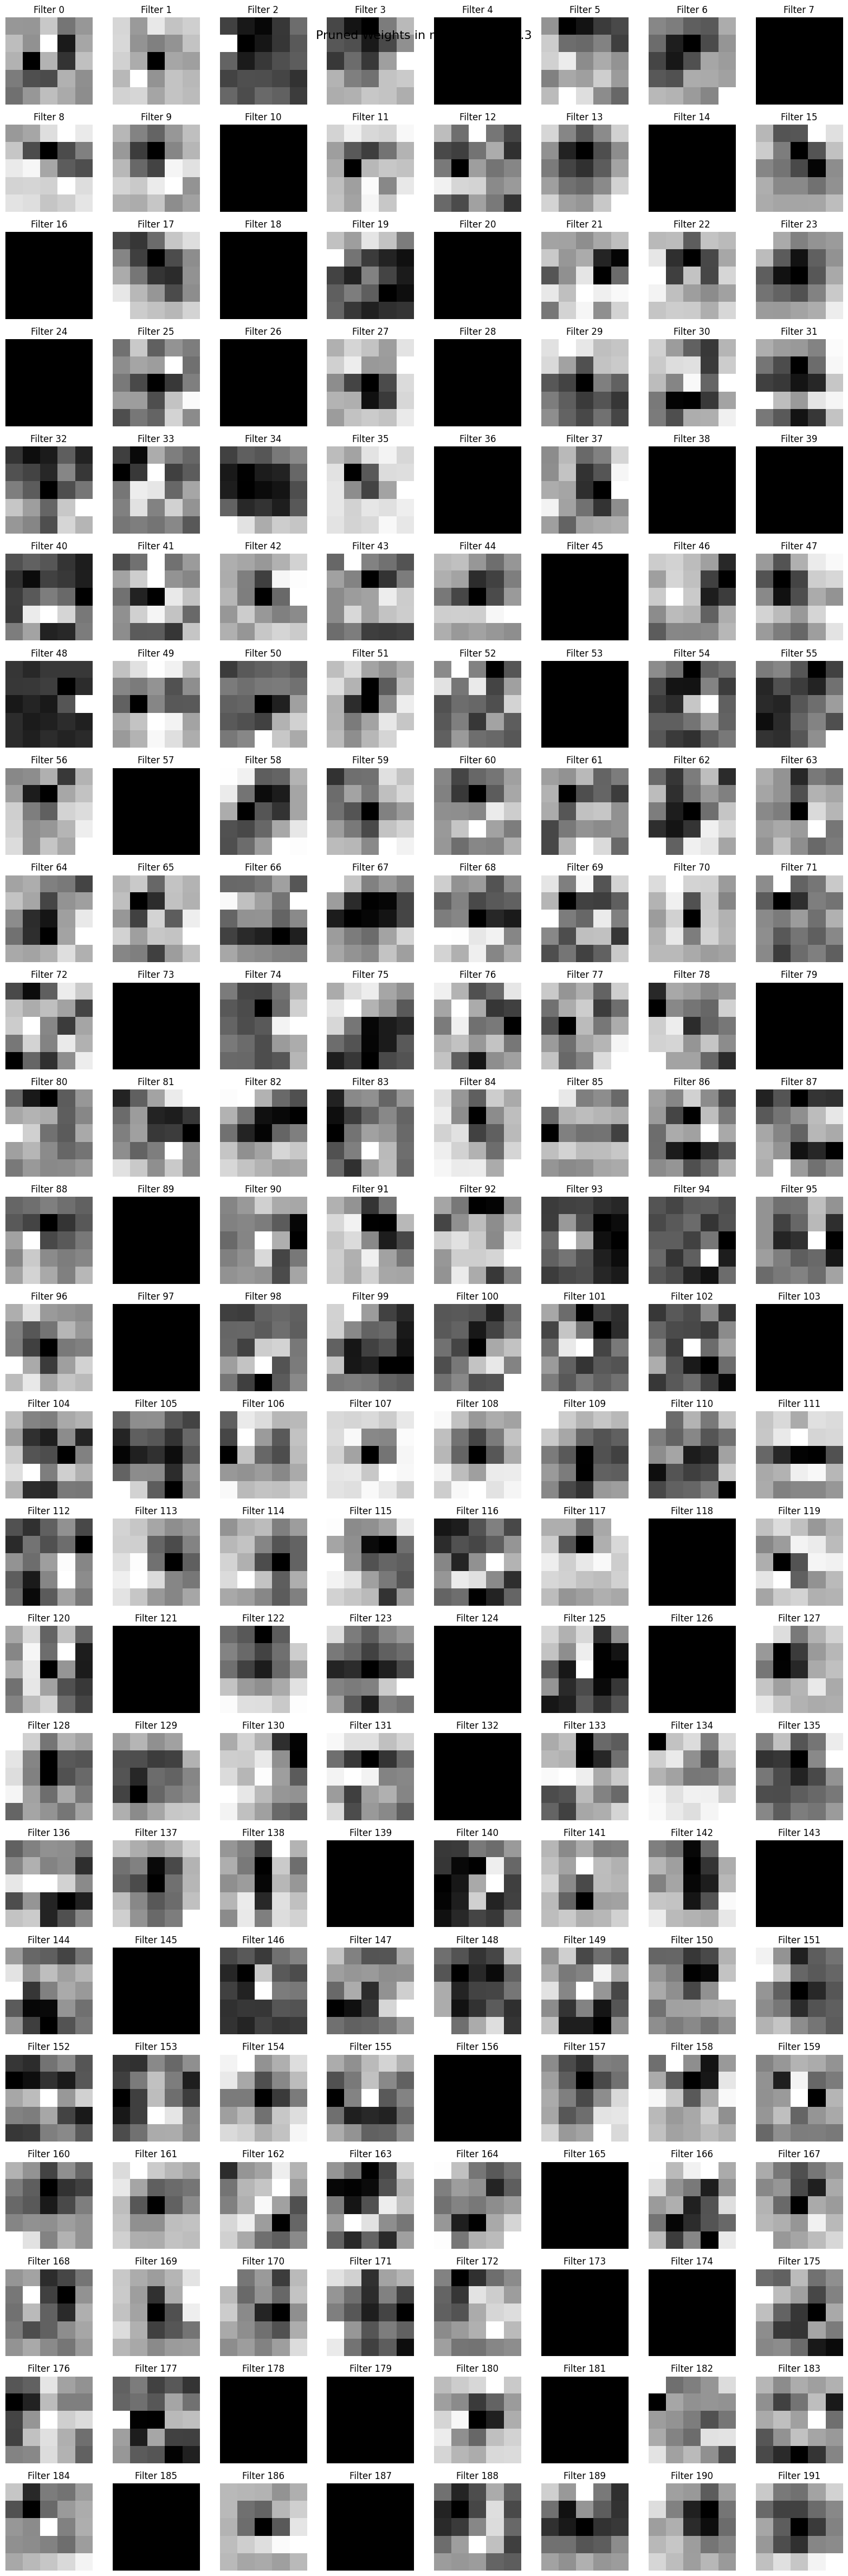

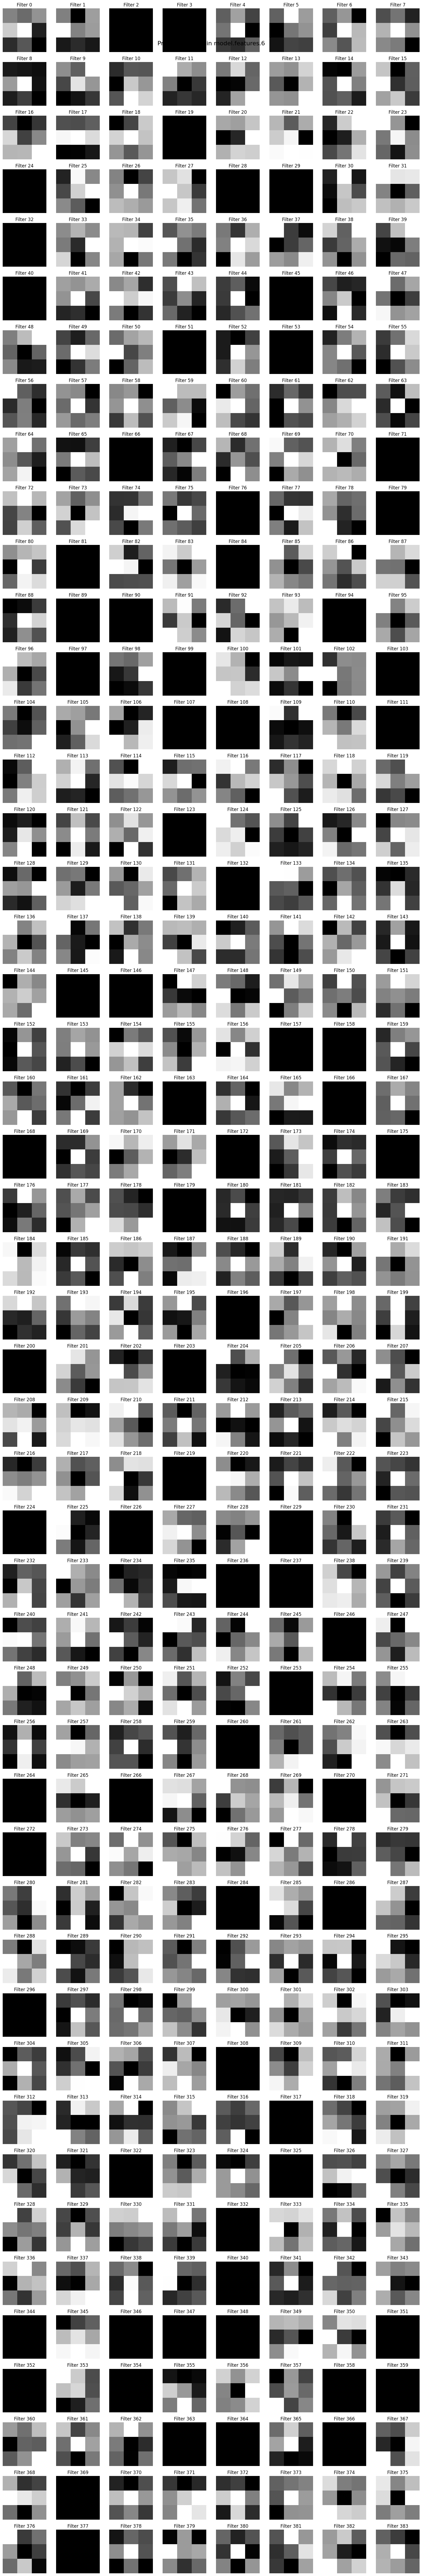

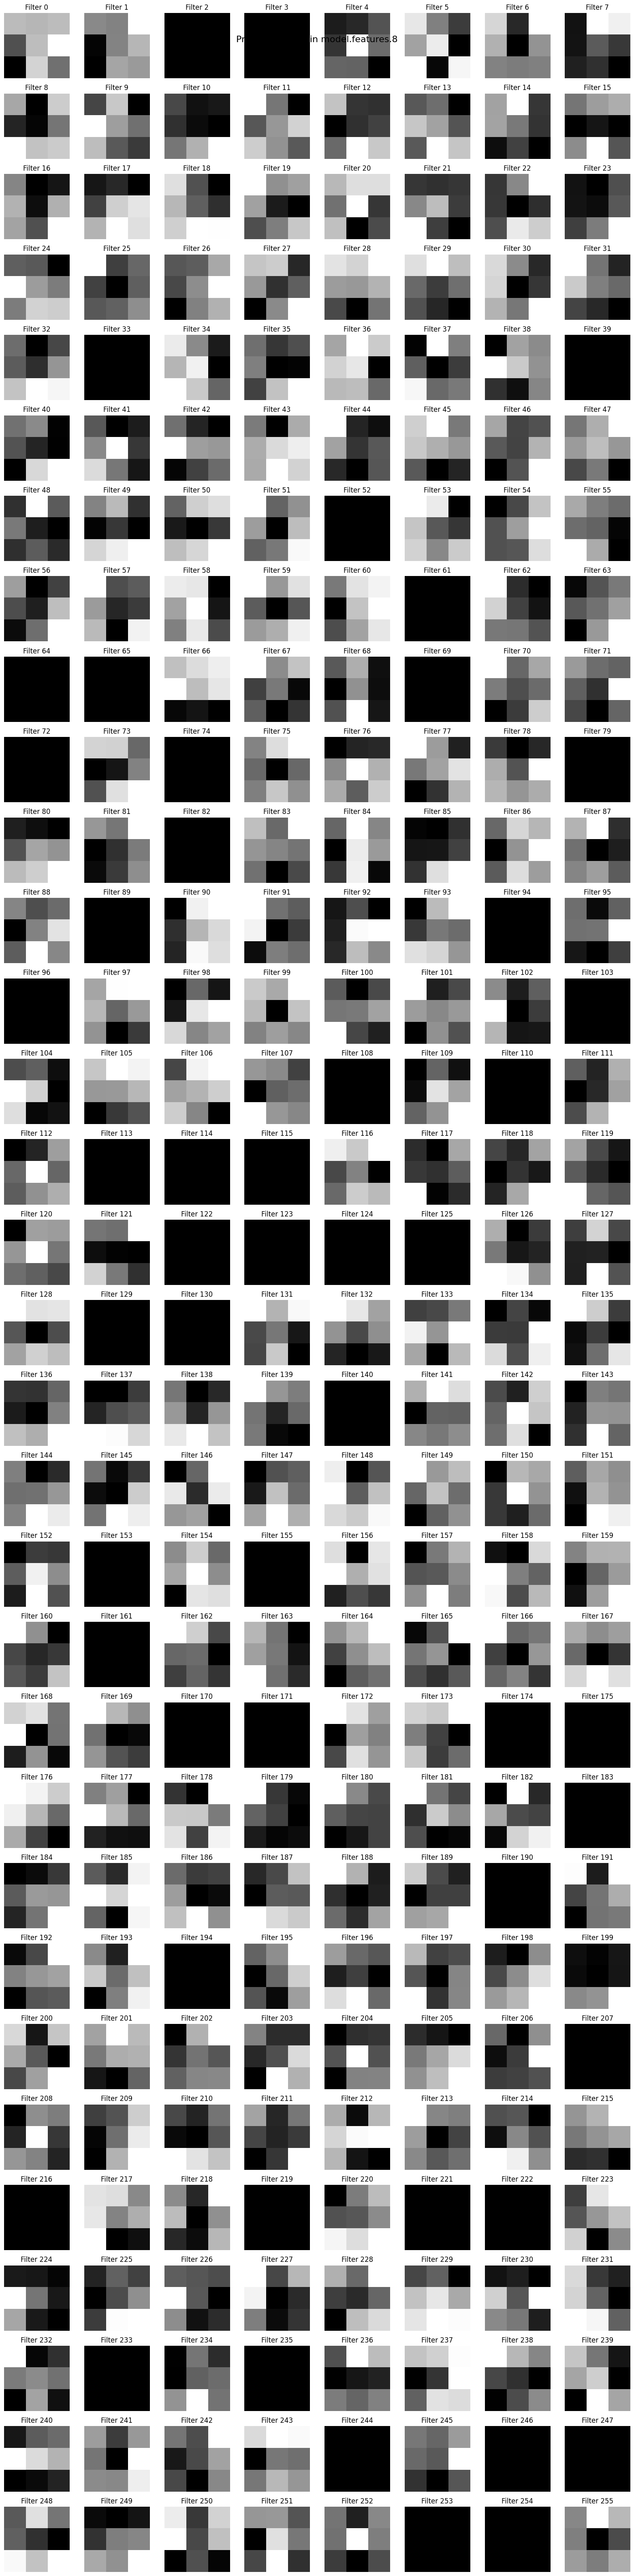

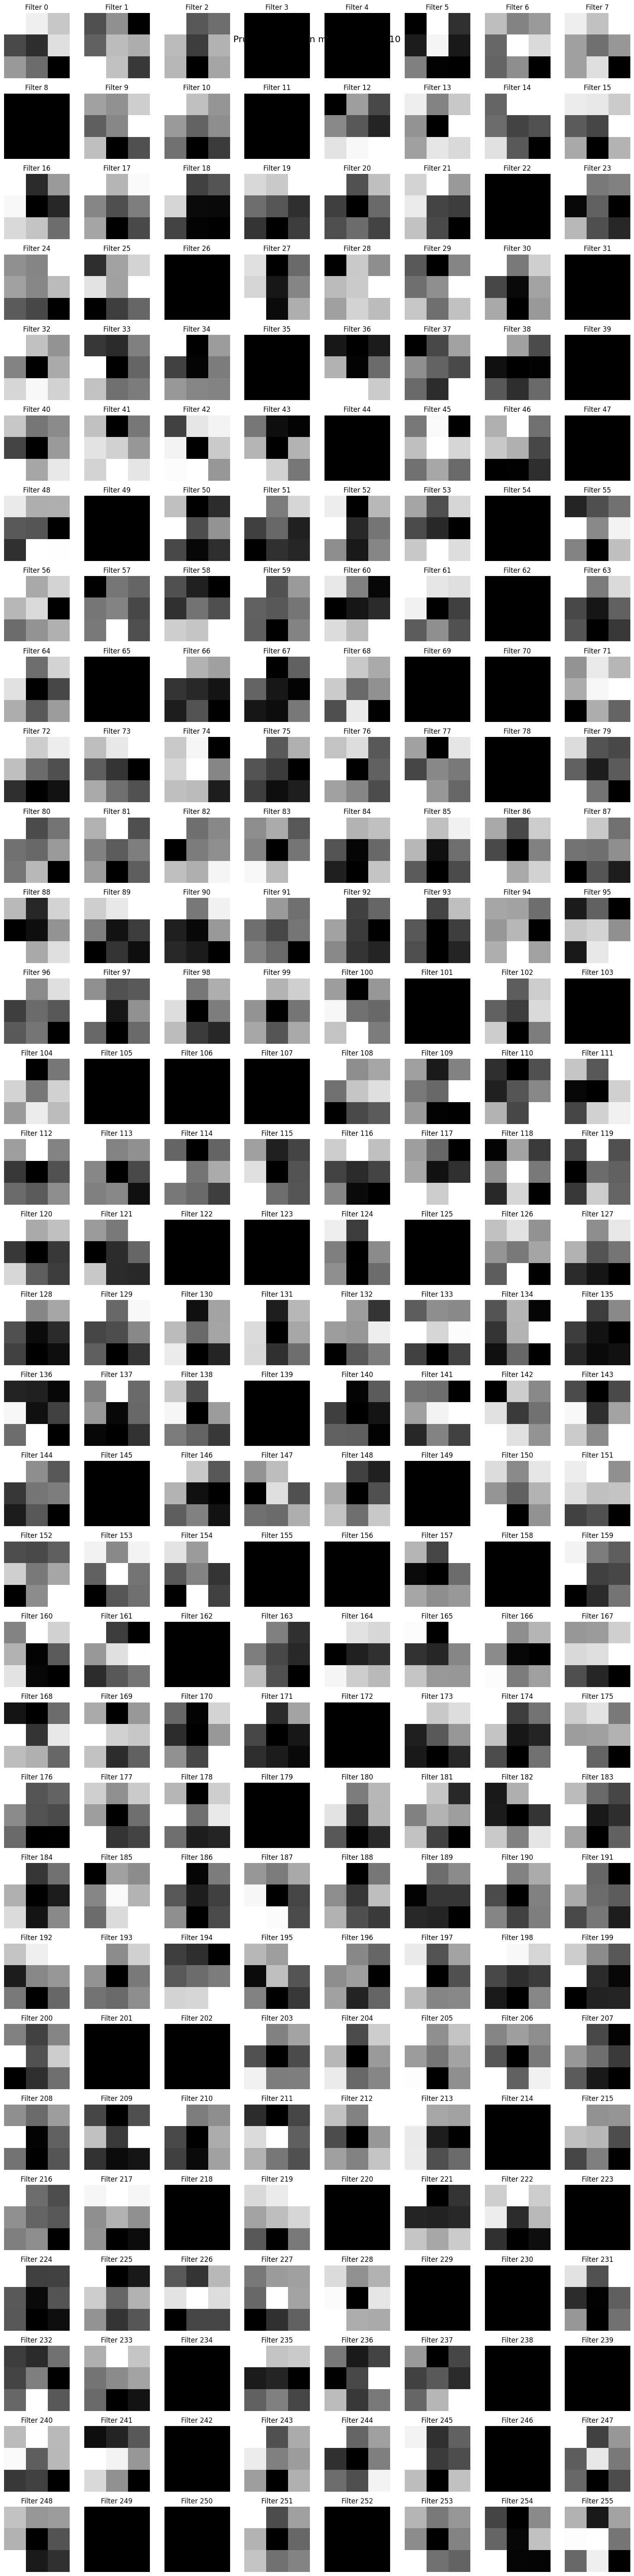

In [8]:
import os
import matplotlib.pyplot as plt
import torch


def visualize_weights(weights, title="Pruned Weights in Conv1", save_path=None, name=None):
    """
    Visualizes and optionally saves the weights of a convolutional layer as 2D images,
    where each image corresponds to one filter in the layer.

    Parameters:
        weights (torch.Tensor): The weight tensor of shape (out_channels, in_channels, height, width).
        title (str): Title for the plot.
        save_path (str): Directory where the image will be saved (optional).
        name (str): Filename for the saved image (optional).
    """
    # Check if the weights tensor is 4D
    if len(weights.shape) != 4:
        raise ValueError(f"Expected 4D weight tensor (Conv2D), but got shape: {weights.shape}")
    
    out_channels, in_channels, height, width = weights.shape

    # Set up subplots to display each output channel
    n_cols = min(8, out_channels)  # Set the number of columns
    n_rows = (out_channels + n_cols - 1) // n_cols  # Calculate the number of rows based on columns

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle(title, fontsize=16)

    # Loop through each filter (output channel) and plot it
    for i in range(out_channels):
        # Visualize the first input channel of each filter
        kernel = weights[i, 0].cpu().detach().numpy()

        # Determine the plot position
        if n_rows > 1:
            ax = axes[i // n_cols, i % n_cols]
        else:
            ax = axes[i % n_cols]
        
        ax.imshow(kernel, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Filter {i}")

    # Hide any remaining empty subplots
    if n_rows > 1:
        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes.flatten()[j])

    # Adjust layout
    plt.tight_layout()

    # Save the visualization if save_path and name are provided
    if save_path and name:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, name))
        print(f"Pruned weights visualization saved to {os.path.join(save_path, name)}")
    else:
        plt.show()

# After pruning a Conv2D layer
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(f"Visualizing weights for {name}")
        visualize_weights(
            module.weight,
            title=f"Pruned Weights in {name}",
            save_path="./plots",
            name=f"{name.replace('.', '_')}_pruned_weights.png"
        )


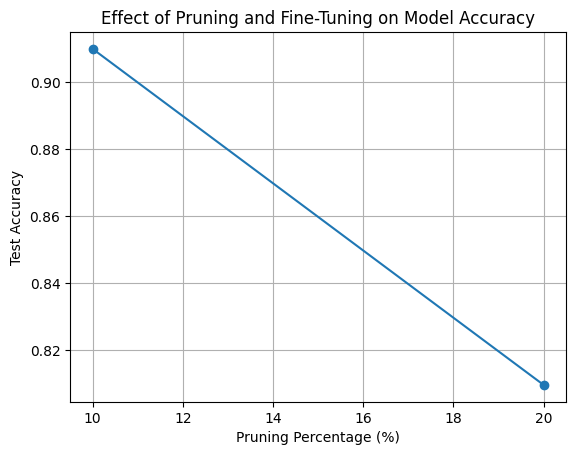

In [9]:
# Plot the results
plt.plot([p * 100 for p in pruning_percentages], accuracies, marker='o')
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy')
plt.title('Effect of Pruning and Fine-Tuning on Model Accuracy')
plt.grid(True)
plt.show()